# ***Imports & Setup***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.ensemble import RandomForestClassifier

sns.set_style("darkgrid")

# ***Load Dataset***

In [2]:
data = fetch_covtype()

In [3]:
X = data.data
y = data.target - 1  # Convert labels from 1–7 to 0–6

In [4]:
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (581012, 54)
Target shape: (581012,)


# ***Train–Test Split & Scaling***

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ***Neural Network Architecture (MLP)***

In [7]:
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(7, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,479 (224.53 KB)

 Trainable params: 56,583 (221.03 KB)

 Non-trainable params: 896 (3.50 KB)

# ***Optimizer & Training Strategy***

In [9]:
optimizer = Adam(learning_rate=0.001)

In [10]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [12]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# ***Model Training***

In [13]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6174 - loss: 1.1919 - val_accuracy: 0.7416 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7298 - loss: 0.6844 - val_accuracy: 0.7676 - val_loss: 0.5752 - learning_rate: 0.0010
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7503 - loss: 0.6182 - val_accuracy: 0.7858 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 4/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7625 - loss: 0.5808 - val_accuracy: 0.7996 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 5/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7757 - loss: 0.5500 - val_accuracy: 0.8126 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 6/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7861 - loss: 0.5273 - val_accuracy: 0.8216 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 7/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7929 - loss: 

# ***Training Curves***

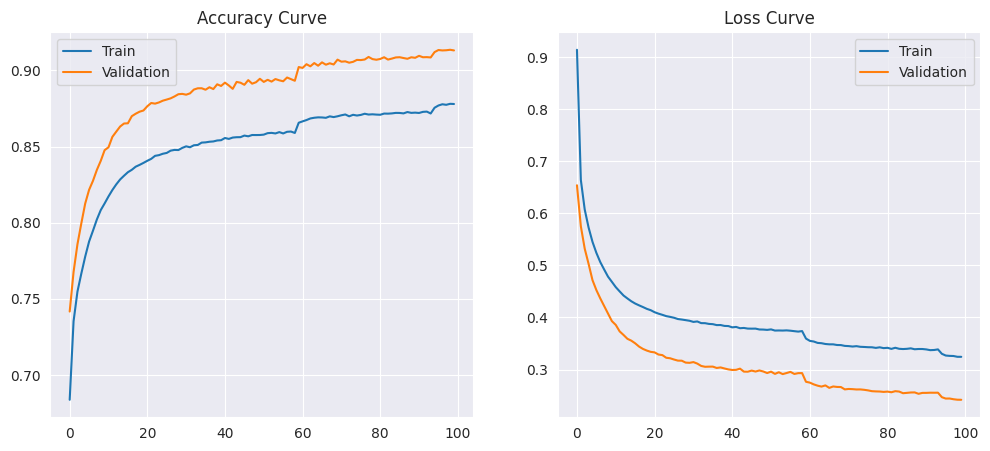

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss Curve")
plt.legend()

plt.show()


# ***Model Evaluation (MLP)***

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [16]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.9131519840279511

Classification Report:

              precision    recall  f1-score   support

           0     0.9343    0.8830    0.9079     42368
           1     0.9083    0.9474    0.9274     56661
           2     0.8857    0.9322    0.9084      7151
           3     0.8951    0.6995    0.7853       549
           4     0.8216    0.6935    0.7521      1899
           5     0.8543    0.8223    0.8380      3473
           6     0.9130    0.9256    0.9193      4102

    accuracy                         0.9132    116203
   macro avg     0.8875    0.8434    0.8626    116203
weighted avg     0.9134    0.9132    0.9126    116203



# ***Confusion Matrix***

In [17]:
cm = confusion_matrix(y_test, y_pred)

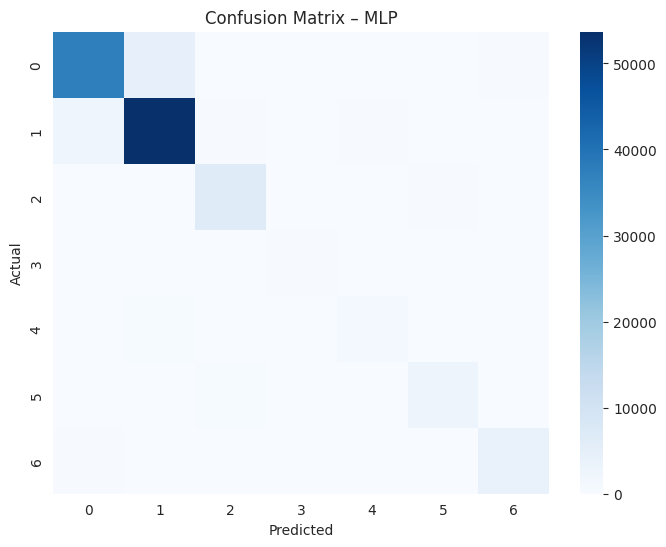

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix – MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ***Ensemble Model: Random Forest***

In [19]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [21]:
rf_preds = rf.predict(X_test)

In [22]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\nClassification Report:\n")
print(classification_report(y_test, rf_preds, digits=4))

Random Forest Accuracy: 0.9546053027890846

Classification Report:

              precision    recall  f1-score   support

           0     0.9652    0.9426    0.9537     42368
           1     0.9494    0.9740    0.9616     56661
           2     0.9392    0.9607    0.9498      7151
           3     0.9116    0.8452    0.8771       549
           4     0.9507    0.7820    0.8581      1899
           5     0.9321    0.8929    0.9121      3473
           6     0.9744    0.9471    0.9606      4102

    accuracy                         0.9546    116203
   macro avg     0.9461    0.9063    0.9247    116203
weighted avg     0.9547    0.9546    0.9544    116203



# ***Confusion Matrix (RF)***

In [23]:
cm_rf = confusion_matrix(y_test, rf_preds)

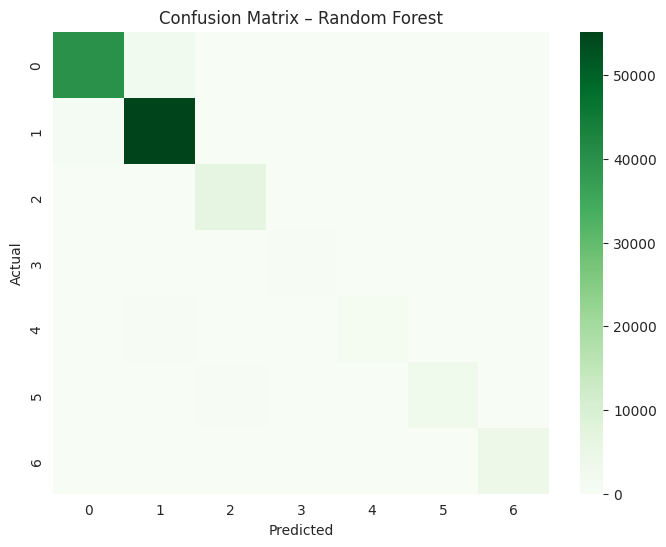

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=False, cmap="Greens")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()